In [1]:
from StorageModel import StorageModel
from mesa.batchrunner import batch_run

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

import numpy as np
import pandas as pd

import time

from IPython import display

In [2]:
MAX_STEPS = 1500
GRID_WIDTH = 20
GRID_HEIGH = 20
N_EXPLORERS = 2
N_COLELCTORS = 3
MAX_FOOD = 47

In [3]:
model = StorageModel((GRID_WIDTH, GRID_HEIGH),
                     (N_EXPLORERS, N_COLELCTORS), MAX_FOOD, True)

for _ in range(MAX_STEPS):
    model.step()
    if not model.running:
        break

In [4]:
data = model.datacollector.get_model_vars_dataframe()
print(len(data))

421


In [5]:
def animate(data):
    fig, axs = plt.subplots(figsize=(3, 3))
    axs.set_xticks([])
    axs.set_yticks([])
    patch = plt.imshow(data[len(data) - 1], cmap=plt.cm.binary)
    plt.clim(0, 3)
    plt.close()
    anim = animation.FuncAnimation(
        fig, lambda i: patch.set_data(data[i]), frames=len(data))
    render = anim.to_jshtml()

    return render

In [6]:

# known = data.get("Known")
# real = data.get("Real")
# agents = data.get("Agents")

# r1 = animate(known)
# r2 = animate(real)
# r3 = animate(agents)

In [7]:
# display.HTML(r1)

In [8]:
# display.HTML(r2)

In [9]:
# display.HTML(r3)

In [10]:
agents_counts = []

for i in range(2, 8):
    agents = list(zip(range(1, i), reversed(range(1, i))))
    agents_counts.extend(agents)

print(agents_counts)

[(1, 1), (1, 2), (2, 1), (1, 3), (2, 2), (3, 1), (1, 4), (2, 3), (3, 2), (4, 1), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1)]


In [11]:
changing_food = batch_run(StorageModel, {
    "shape": [(GRID_WIDTH, GRID_HEIGH)],
    "agents": [(2, 3)],
    "max_food": range(MAX_FOOD*2),
    # "max_food": 2,
    "render": [False],
    "simulating": [True]
}, max_steps=MAX_STEPS, number_processes=16)

  0%|          | 0/94 [00:00<?, ?it/s]

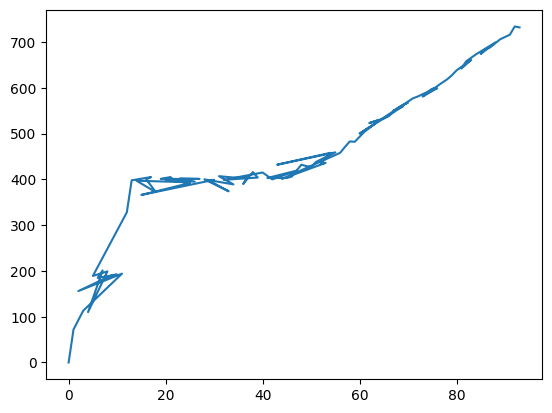

In [18]:
changing_food.sort(key=lambda x: x.get("max_food"))
steps = list(map(lambda x: x.get("Steps"), changing_food))
max_foods = list(map(lambda x: x.get("max_food"), changing_food))
plt.plot(max_foods, steps)
